# 基于HDDM拟合2back任务

## 1.加载packages

In [1]:
import sys

print("Python 版本:", sys.version)

Python 版本: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:23:23) 
[GCC 10.3.0]


In [2]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## 2.导入数据集

In [3]:
! pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 310.1 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import hddm
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_path = './rawdata.xlsx'
trial_data = pd.read_excel(file_path)

# 清理列名中的空格
trial_data.columns = trial_data.columns.str.strip()

# 确保反应时间列 'rt' 被转换为浮点数类型
trial_data['rt'] = pd.to_numeric(trial_data['rt'], errors='coerce')

# 确保 'Group' 列的数据类型为字符串，并去除可能的空格
trial_data['Group'] = trial_data['Group'].astype(str).str.strip()

# 检查数据
print(trial_data.tail())
print(f"The number of trials: {trial_data.shape[0]}")
print(f"The number of variables: {trial_data.shape[1]}")
print(f"The number of participants: {trial_data['subj_idx'].unique().shape[0]}")

# 重新命名必要的列，确保与 HDDM 的要求一致
data = hddm.utils.flip_errors(trial_data)

# 数据检查完成，准备后续模型的构建

          ID  subj_idx  response     rt Group
16296  16363       272         1  0.123     1
16297  16364       272         1  0.172     1
16298  16365       272         0  0.027     1
16299  16366       272         0  0.023     1
16300  16367       272         0  0.143     1
The number of trials: 16301
The number of variables: 5
The number of participants: 211


In [5]:
data=trial_data

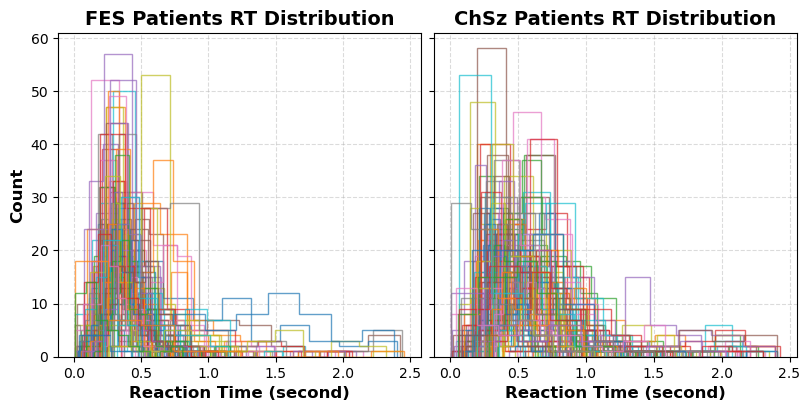

In [6]:
import matplotlib.pyplot as plt

# 分组标签映射（字符串类型）
group_labels = {
    '1': 'FES Patients',
    '2': 'ChSz Patients'
}

# 确保组的顺序为 ['1', '2']
groups = ['1', '2']

# 创建子图
fig, axs = plt.subplots(1, len(groups), figsize=(8, 4), sharey=True, constrained_layout=True)

for idx, group in enumerate(groups):
    group_data = data[data['Group'] == group]
    ax = axs[idx]  # 当前子图
    ax.set_title(f"{group_labels[group]} RT Distribution", fontsize=14, weight='bold')
    
    # 绘制每个 subj_idx 的反应时间分布
    for subj_idx, subj_data in group_data.groupby('subj_idx'):
        subj_data.rt.hist(bins=10, histtype='step', ax=ax, alpha=0.7)
    
    ax.set_xlabel('Reaction Time (second)', fontsize=12, weight='bold')
    if idx == 0:  # 仅在第一个子图中设置 Y 轴标签
        ax.set_ylabel('Count', fontsize=12, weight='bold')
    
    # 添加网格线
    ax.grid(axis='both', linestyle='--', alpha=0.45)  # 设置网格线为虚线，透明度为 0.7

# 保存图像
plt.savefig('rt_distributions_by_group_with_grid.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [7]:
# 检查 Group 列的唯一值及其数据类型
print(data['Group'].unique())
print(data['Group'].dtype)

# 确保 Group 列的值为字符串类型，并移除可能存在的空格
data['Group'] = data['Group'].astype(str).str.strip()

# 再次计算 Group 1 和 Group 2 中的唯一被试数量
unique_group1_subjects = data[data['Group'] == '1']['subj_idx'].nunique()
unique_group2_subjects = data[data['Group'] == '2']['subj_idx'].nunique()

print(f"First episode of schizophrenia = {unique_group1_subjects}")
print(f"Chronic schizophrenia = {unique_group2_subjects}")

['2' '1']
object
First episode of schizophrenia = 103
Chronic schizophrenia = 108


#### 1.模型设计

In [8]:
import hddm

# 打印数据的类型，确保数据格式正确
# 数据应为一个 Pandas DataFrame，包含反应时间（RT）、正确性（accuracy）以及组别等列
print(f"Data type: {type(data)}")

# 基础模型（m0）：包含所有核心参数和变异性参数
# 该模型不考虑条件或组别，只用于全局参数估计
m0 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'sz', 'st']  # 包含所有参数和变异性参数
)

# 综合模型（m2）：分层模型，探索所有组别间参数的变化
# 假设核心参数（a, v, t, z）依赖于组别（Group）
m1 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],  # 包含所有核心参数和变异性参数
    depends_on={  # 假设参数依赖于组别
        'a': ['Group'], 
        'v': ['Group'], 
        't': ['Group'],
        'z': ['Group']
    }
)


# 回归模型（m3v）：分析组别对漂移率（v）的影响
m2v = hddm.HDDMRegressor(
    data,
    "v ~ 1 + C(Group, Treatment('2'))",  # 漂移率 v 的回归公式，Group 为分组变量，'2' 为参考组
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],  # 包含所有核心参数和变异性参数
    group_only_regressors=False,  # 允许个体层面的变化
    keep_regressor_trace=True  # 保留回归系数的 MCMC 采样轨迹
)

# 回归模型（m3z）：分析组别对起始点偏移（z）的影响
m2z = hddm.HDDMRegressor(
    data,
    "z ~ 1 + C(Group, Treatment('2'))",  # 起始点 z 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 回归模型（m3a）：分析组别对决策界限（a）的影响
m2a = hddm.HDDMRegressor(
    data,
    "a ~ 1 + C(Group, Treatment('2'))",  # 决策界限 a 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 回归模型（m3t）：分析组别对非决策时间（t）的影响
m2t = hddm.HDDMRegressor(
    data,
    "t ~ 1 + C(Group, Treatment('2'))",  # 非决策时间 t 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 打印模型初始化完成的信息
print('模型已成功初始化！😄')

Data type: <class 'pandas.core.frame.DataFrame'>
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
模型已成功初始化！😄


#### 2.模型拟合参数量 

In [9]:
def run_sampling(
    m,
    n_samples=10000,  # 10,000
    n_burn=5000,     # 5000
    n_chains=4,      # 4
    thin=2,  # Thinning：每隔2个样本保留1个
    model_name="m",
    progress_bar=True
):
    m_infdata = m.sample(
        n_samples,
        burn=n_burn,
        chains=n_chains,
        return_infdata=True,
        save_name="8.model_fitted/" + model_name,
        progress_bar=progress_bar
    )

    return m, m_infdata


# 计算时间估计
print('拟合参数设置成功!')

拟合参数设置成功!


In [ ]:
import time
import dill as pickle  # 使用dill代替pickle

# 模型和名称列表
models = [m2v]
model_names = ["m2v"]

# 创建一个字典存储结果
results = {}

for model, name in zip(models, model_names):
    print(f"Running model {name}... 🏃🏃🏃")
    start_time = time.time()
    
    # 运行采样
    model, model_infdata = run_sampling(model, model_name=name)
    elapsed_time = time.time() - start_time
    
    # 保存模型和结果
    with open(f'./2.模型拟合-输出/{name}_model.pkl', 'wb') as f_model:
        pickle.dump(model, f_model)
        
    with open(f'./2.模型拟合-输出/{name}_infdata.pkl', 'wb') as f_infdata:
        pickle.dump(model_infdata, f_infdata)
    
    results[name] = (model, model_infdata)
    
    print(f"Model {name} completed in {elapsed_time:.2f} seconds.\n")
    print(f"Model {name} and inference data saved as {name}_model.pkl and {name}_infdata.pkl.\n")

print('模型训练全部完成 😂!')

Running model m2v... 🏃🏃🏃


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[                  0%                  ] 2 of 10000 complete in 2.0 sec
[                  0%                  ] 3 of 10000 complete in 4.5 sec
[                  0%                  ] 4 of 10000 complete in 7.2 sec
[                  0%                  ] 5 of 10000 complete in 10.2 sec
[                  0%                  ] 6 of 10000 complete in 12.9 sec
[                  0%                  ] 7 of 10000 complete in 15.6 sec
[                  0%                  ] 8 of 10000 complete in 19.2 sec
[                  0%                  ] 9 of 10000 complete in 23.2 sec
[                  0%                  ] 10 of 10000 complete in 27.4 sec
[                  0%                  ] 11 of 10000 complete in 31.2 sec
[                  0%                  ] 12 of 10000 complete in 35.6 sec
[                  0%                  ] 13 of 10000 complete in 39.6 sec
[                  0%                  ] 14 of 10000 complete in 43.8 sec
[                  0%                  ] 15 of 10

**注：在配备 2.90GHz 英特尔®酷睿™i7-10700 处理器的电脑上，用上述设置（10000 个样本）拟合所有这六个模型大约需要 8-9 个小时。此外，内存应足够大，建议使用 ~ 64 G 内存。否则，建议使用少量样本（如 n_samples=2500，burn=1000）。

#### 3.读取之前好的模型😂

In [10]:
import pickle

# 模型和推断数据的文件名
model_names = ["m0","m1"] 
 
# 创建字典存储模型和推断数据
models = {}
infdata = {}

# 加载所有模型和推断数据
for name in model_names:
    model_file_path = f'./2.模型拟合-输出/{name}_model.pkl'
    infdata_file_path = f'./2.模型拟合-输出/{name}_infdata.pkl'
    
    # 重新加载模型
    with open(model_file_path, 'rb') as f_model:
        models[name] = pickle.load(f_model)
    
    # 重新加载推断数据
    with open(infdata_file_path, 'rb') as f_infdata:
        infdata[name] = pickle.load(f_infdata)
    
    # 动态赋值回原始变量名
    globals()[name] = models[name]
    globals()[f"{name}_infdata"] = infdata[name]
    
    print(f"{name} 已经成功挂载!")

# 打印已加载的模型和推断数据
for name in model_names:
    print(f"{name} 模型:", globals()[name])
    print(f"{name} 推断数据:", globals()[f"{name}_infdata"])

print('所有模型和推断数据读取成功!😂')

m0 已经成功挂载!
m1 已经成功挂载!
m0 模型: <hddm.models.hddm_info.HDDM object at 0xffff89970040>
m0 推断数据: Inference data with groups:
	> posterior
	> observed_data
m1 模型: <hddm.models.hddm_info.HDDM object at 0xffffac12fca0>
m1 推断数据: Inference data with groups:
	> posterior
	> observed_data
所有模型和推断数据读取成功!😂


In [11]:
import pickle

# 定义模型名称列表
model_names = ["m0","m1"]
posterior_distributions = {}

# 循环加载每个模型并提取后验分布
for model_name in model_names:
    print(f"提取 {model_name} 的后验分布...")
    
    # 加载模型
    with open(f'./2.模型拟合-输出/{model_name}_model.pkl', 'rb') as f_model:
        model_loaded = pickle.load(f_model)
    
    # 提取后验分布
    posterior_samples = model_loaded.get_traces()
    
    # 将每个模型的后验分布存储在字典中
    posterior_distributions[model_name] = posterior_samples
    
    # 打印提取的后验分布的前几行
    print(f"{model_name}的后验分布提取完成:")

print("所有模型的后验分布提取完成！😂")


#得20分钟

提取 m0 的后验分布...
m0的后验分布提取完成:
提取 m1 的后验分布...
m1的后验分布提取完成:
所有模型的后验分布提取完成！😂


#### 4.查看内存

In [12]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available memory: 18.69 GB


## 3.模型诊断

In [13]:
import arviz as az
import pandas as pd

# 获取每个模型中存储的变量名称并排除含有 'subj' 的变量
model_data = {}
filtered_model_data = {}

# 模型 m0 到 m4 的变量存储
for i, infdata in enumerate([m0_infdata]):
    model_name = f'm{i}'  # m0, m1, m2, m3, m4
    # 获取变量名称
    var_names = list(infdata.posterior.data_vars)
    model_data[model_name] = var_names
    
    # 排除包含 'subj' 的变量
    filtered_var_names = [var for var in var_names if 'subj' not in var]
    filtered_model_data[model_name] = filtered_var_names

# 将完整数据转换为 DataFrame 并保存到 Excel
df_model_data = pd.DataFrame.from_dict(model_data, orient='index').transpose()
df_model_data.to_excel('3.模型诊断-输出/model_variables_full.xlsx', index=False)

# 将排除含有 'subj' 的数据保存到另一个 Excel
df_filtered_model_data = pd.DataFrame.from_dict(filtered_model_data, orient='index').transpose()
df_filtered_model_data.to_excel('3.模型诊断-输出/model_variables_filtered.xlsx', index=False)

# 打印过滤后的模型变量名称
print('保存完成！')

保存完成！


#### （1）方法1.Trace plot

We can also only plot selected parameters' traces. 
 
- use regex to select var_names that start with "a" and do not contain either "subj" or "std".

print(tmp_infdata.posterior.dims)
print(tmp_infdata.posterior.coords)
print(tmp_infdata.posterior.data_vars)##### M0

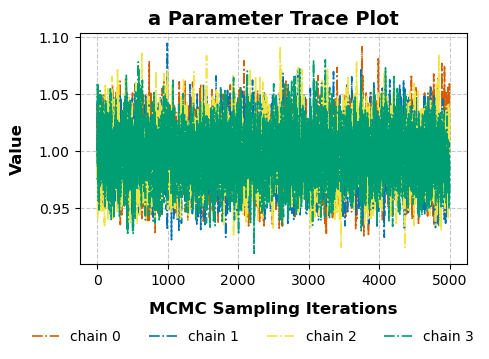

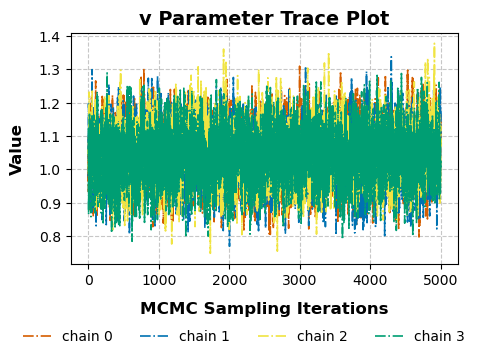

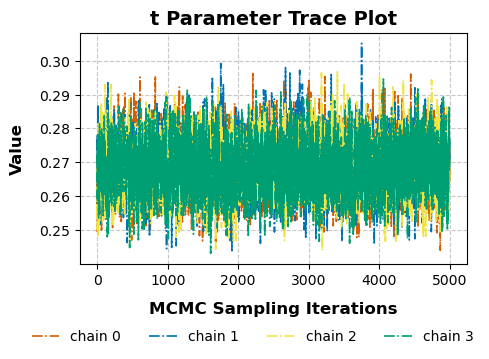

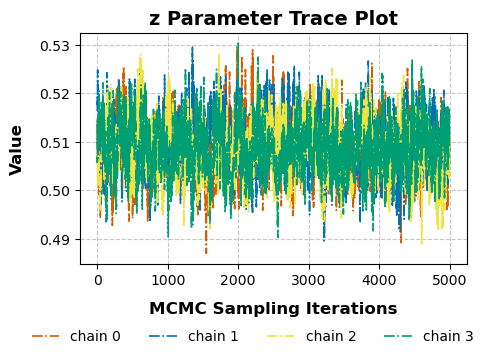

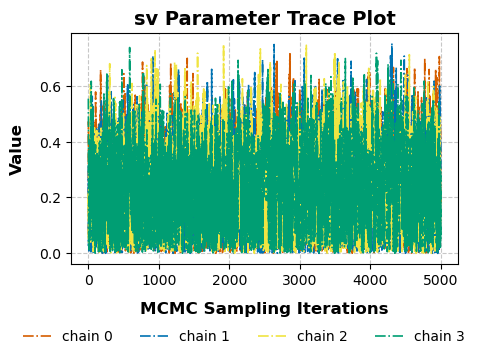

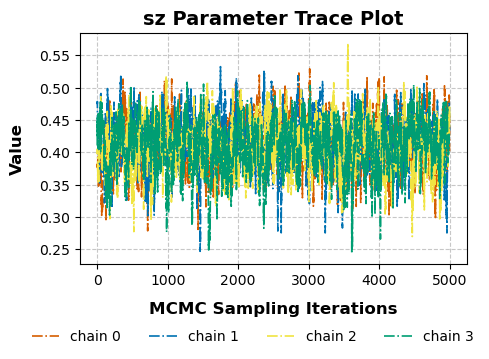

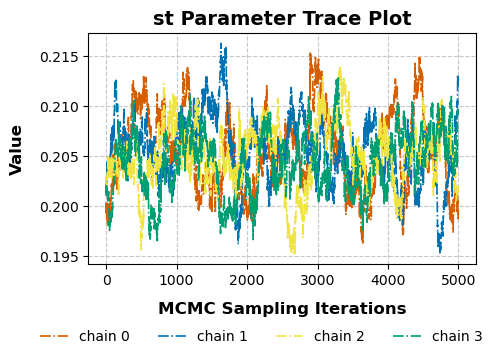

In [14]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m0']  

# 定义需要检查的参数
parameters = ['a', 'v', 't', 'z', 'sv', 'sz', 'st']

# 自定义 chain 颜色（为4个链设置颜色）

chain_colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73']  # 高对比Nature风格配色
# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=12, fontweight='bold', labelpad=10)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=12, fontweight='bold', labelpad=10)  # 设置 Y 轴标签，增加 pad 和粗体

            # 设置标题，将 var_name 和 'Trace Plot' 结合
            ax.set_title(f'{param} Parameter Trace Plot', fontsize=14, fontweight='bold')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存图片为 600 DPI 的 JPEG 格式到对应模型的文件夹
            plt.savefig(f'{output_folder}/{model_name}_{param}_trace_plot.jpg', dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

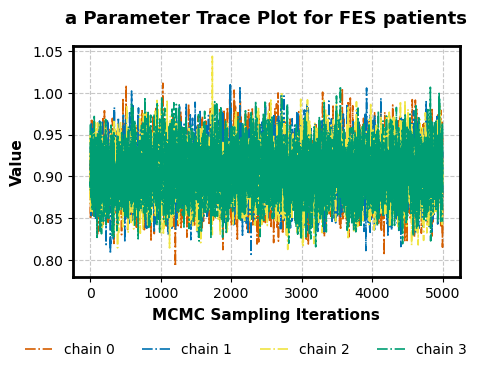

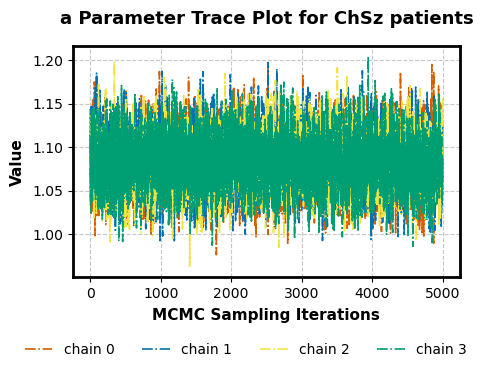

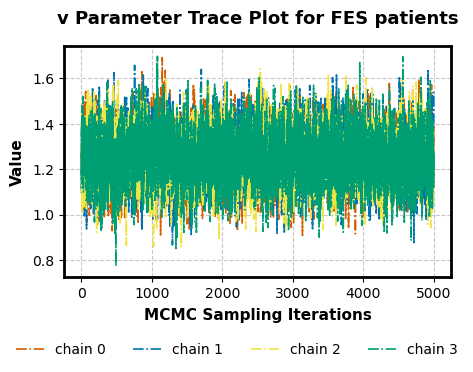

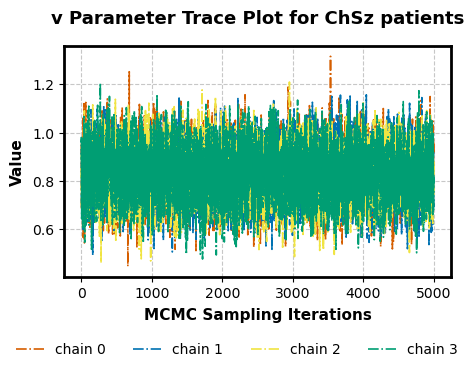

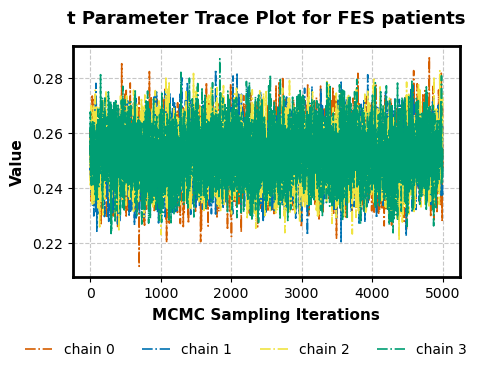

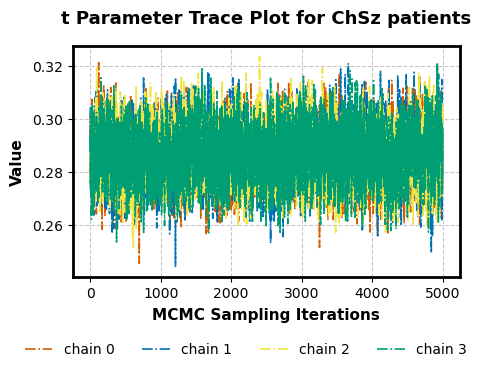

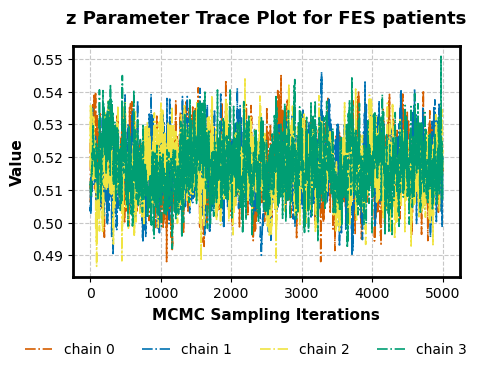

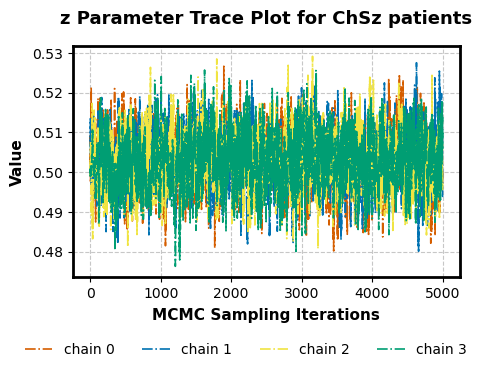

In [15]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m1']  

# 定义需要检查的参数
parameters = ['a(1)', 'a(2)', 'v(1)', 'v(2)', 't(1)', 't(2)', 'z(1)', 'z(2)']

# 自定义 chain 颜色（为4个链设置颜色）
chain_colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73']  # 高对比Nature风格配色

# 模型的患者组信息
model_patient_groups = {
    'a(1)': 'FES patients',
    'a(2)': 'ChSz patients',
    'v(1)': 'FES patients',
    'v(2)': 'ChSz patients',
    't(1)': 'FES patients',
    't(2)': 'ChSz patients',
    'z(1)': 'FES patients',
    'z(2)': 'ChSz patients',
    'sv': 'FES patients',
    'st': 'ChSz patients'
}

# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 移除参数中的数字括号部分，例如 'a(1)' 变为 'a'
        param_clean = param.split('(')[0]  # 仅保留参数名称的前部分
        
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=11, fontweight='bold', labelpad=5)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=11, fontweight='bold', labelpad=5)  # 设置 Y 轴标签，增加 pad 和粗体

            # 获取患者组信息，并生成合适的标题
            patient_group = model_patient_groups.get(param, 'Unknown group')
            ax.set_title(f'{param_clean} Parameter Trace Plot for {patient_group}', fontsize=13, fontweight='bold', y=1.06)

            # 设置边框颜色为黑色，并加粗
            ax.spines['top'].set_color('black')
            ax.spines['top'].set_linewidth(2)  # 设置上边框的线宽

            ax.spines['bottom'].set_color('black')
            ax.spines['bottom'].set_linewidth(2)  # 设置下边框的线宽

            ax.spines['left'].set_color('black')
            ax.spines['left'].set_linewidth(2)  # 设置左边框的线宽

            ax.spines['right'].set_color('black')
            ax.spines['right'].set_linewidth(2)  # 设置右边框的线宽
            
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存每个参数的 Trace Plot，确保文件名包含每个参数
            output_file_path = f'{output_folder}/{model_name}_{param}_trace_plot.jpg'
            plt.savefig(output_file_path, dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

#### （2）方法2. $\hat{R}$ and ESS

In [16]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m0_infdata]  # 使用正确的全局变量名
model_names = ['m0']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m0:
Empty DataFrame
Columns: [mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
已成功将问题参数保存至 problem_params-m0.xlsx 文件
收敛良好的参数😂 - m0:
            mcse_mean  mcse_sd   ess_bulk    ess_tail   r_hat
a              0.0003   0.0002  5371.6187   9453.2428  1.0003
a_std          0.0002   0.0002  6408.5410   9981.9335  1.0006
a_subj.2       0.0008   0.0006  8279.2323  11432.2562  1.0005
a_subj.4       0.0009   0.0006  5224.9406   6069.3663  1.0004
a_subj.5       0.0006   0.0004  8672.2262  11073.8156  1.0005
...               ...      ...        ...         ...     ...
z_subj.263     0.0005   0.0003  3618.0684   8496.6525  1.0006
z_subj.264     0.0004   0.0003  5771.8298   7338.2034  1.0012
z_subj.265     0.0004   0.0003  8627.5353   7734.2131  1.0012
z_subj.266     0.0003   0.0002  9098.3049   7247.5173  1.0005
z_subj.272     0.0005   0.0003  4272.6987   7764.9357  1.0008

[855 rows x 5 columns]
已成功将收敛良好的参数保存至 good_params-m0.xlsx 文件
模型 m0 的 ESS 值：
<bound method Mapping.values of

In [17]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m1_infdata]  # 使用正确的全局变量名
model_names = ['m1']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m1:
Empty DataFrame
Columns: [mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
已成功将问题参数保存至 problem_params-m1.xlsx 文件
收敛良好的参数😂 - m1:
               mcse_mean  mcse_sd    ess_bulk    ess_tail   r_hat
a(1)              0.0003   0.0002   8330.9557  13311.5355  1.0004
a(2)              0.0003   0.0002   8034.3521  12269.8068  1.0007
a_std             0.0002   0.0002   5761.5067  10782.2145  1.0007
a_subj(1).4       0.0008   0.0006   5771.8697   7107.0626  1.0013
a_subj(1).5       0.0006   0.0004   8427.4616  10097.2500  1.0006
...                  ...      ...         ...         ...     ...
z_subj(2).259     0.0003   0.0002   9565.3845   9271.7848  1.0002
z_subj(2).261     0.0003   0.0002  12581.8908   9581.4426  1.0004
z_subj(2).262     0.0006   0.0004   3762.7726   6622.7184  1.0004
z_subj(2).264     0.0004   0.0003   6438.4713   8262.6729  1.0003
z_subj(2).266     0.0003   0.0002   9257.8674  11508.6124  1.0001

[859 rows x 5 columns]
已成功将收敛良好的参数保存至 good_params-m1.xlsx 文

## 4. 模型比较与选择 (基于DIC)

In [18]:
! pip3 install tabulate


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


+---------+---------+
| model   |     DIC |
+=========+=========+
| Model 1 | 5921.85 |
+---------+---------+
| Model 0 | 5927.66 |
+---------+---------+


/tmp/ipykernel_50/3438262573.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)


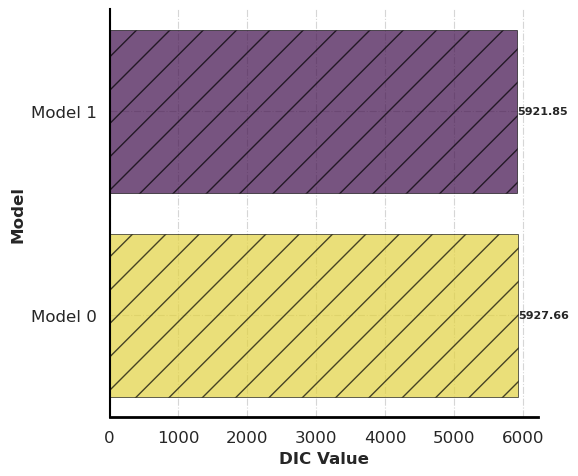

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 模拟DIC数据，使用模型的具体名称
dic_dict = {
    "Model 1": m0.dic,
    "Model 0": m1.dic,
}

# 将字典转换为Pandas DataFrame,并按照DIC值升序排序
comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic = comp_dic.sort_values(by=['DIC'], ascending=True)

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

# 设置绘图风格，使用符合Nature风格的简洁主题
sns.set(style="whitegrid", font_scale=1.2)

# 创建颜色映射，颜色越大越深
norm = plt.Normalize(comp_dic['DIC'].min(), comp_dic['DIC'].max())
colors = plt.cm.viridis(norm(comp_dic['DIC']))  # 使用 vivid 色彩映射

# 创建柱状图，将 X 和 Y 轴对调
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)

# 为柱状图中的每个柱子设置透明度、边框粗细和花纹
for patch in bar_plot.patches:
    patch.set_alpha(0.7)  # 设置透明度为0.7
    patch.set_edgecolor('black')  # 设置边框颜色为黑色
    patch.set_linewidth(0.6)  # 设置边框粗细为0.6
    patch.set_hatch('/')  # 设置花纹，'/'表示斜线

# 在柱子上标注具体数值
for i, patch in enumerate(bar_plot.patches):
    width = patch.get_width()
    bar_plot.text(width + 0.5,  # 数值标签的x坐标稍高于柱子顶部
                  patch.get_y() + patch.get_height() / 2,
                  f'{width:.2f}',  # 显示2位小数
                  ha='left', 
                  va='center', 
                  fontsize=8, 
                  weight='bold')

# 添加图形标题和坐标轴标签
bar_plot.set_ylabel("Model", fontsize=12, weight='bold')
bar_plot.set_xlabel("DIC Value", fontsize=12, weight='bold')

# 调整标签和风格，参考Nature风格
bar_plot.tick_params(axis='both', which='major', labelsize=12)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)

# 设置左和底部的边框为黑色，并加粗
bar_plot.spines['left'].set_linewidth(1.5)
bar_plot.spines['left'].set_color('black')  # 改为黑色
bar_plot.spines['bottom'].set_linewidth(2)
bar_plot.spines['bottom'].set_color('black')  # 改为黑色

# 设置网格线的透明度和粗细
bar_plot.grid(True, which='major', axis='x', linestyle='-.', linewidth=0.8, alpha=0.8)  # 现在对x轴应用网格线
bar_plot.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.8, alpha=0.8)

# 调整布局以防止标签被截断
plt.tight_layout()

# 保存图片到指定文件夹，并确保不会截断图像
plt.savefig("4.模型比较-输出/DIC_comparison.jpeg", dpi=600, format='jpeg', bbox_inches='tight')  # 使用bbox_inches='tight'来防止截断

# 显示图形
plt.show()

In [20]:
# 计算模型间的 DIC 差异
comp_dic['ΔDIC'] = comp_dic['DIC'] - comp_dic['DIC'].min()

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

+---------+---------+---------+
| model   |     DIC |    ΔDIC |
+=========+=========+=========+
| Model 1 | 5921.85 | 0       |
+---------+---------+---------+
| Model 0 | 5927.66 | 5.80568 |
+---------+---------+---------+


## 5. Posterior predictive check

In [ ]:
%time
m2_infdata = m2.to_infdata(loglike = True, ppc = True, n_ppc = 50, save_name = "model_fitted/m0")

In [ ]:
print('m2生成PPC 好了😄!')

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# 重设坐标
m2_infdata = m2_infdata.assign_coords(
  obs_id=m2_infdata.observed_data.coords['subj_idx'].values, 
  groups="observed_vars"
)

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))  # 1x2布局的子图

# 获取图例句柄和标签
lines = []
labels = []

# 定义观察组的ID和标题
obs_ids = [4, 2]  # 选择不同的 obs_id 作为例子
group_titles = ['FES patients (Subject 1)', 'ChSz patients(Subject 1)']  # 设置标题

# 绘制每个子图
for i, ax in enumerate(axes):
    az.plot_ppc(
        m0_infdata, 
        var_names='rt', 
        coords={'obs_id': [obs_ids[i]]},  # 使用当前 obs_id
        num_pp_samples=100,  # 设置后验样本数量
        random_seed=2023, 
        flatten=[], 
        textsize=20,  # 调整文本大小
        alpha=0.2,    # 设置透明度
        color='darkgreen',  # 设置颜色
        ax=ax,  # 在指定子图中绘制
        kind='kde',  # 使用核密度估计（kde）绘图
    )
    
    # 设置每个子图的标题和标签
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold')  # 设置标题字体和大小
    ax.set_xlabel('rt', fontsize=14)  # 设置x轴标签
    ax.set_ylabel('Density', fontsize=14)  # 设置y轴标签
    
    # 隐藏网格线
    ax.grid(False)

    # 自定义x轴刻度和标签
    ax.set_xticks([-2, 0, 2])  # 设置x轴刻度
    ax.set_xticklabels(['-2', '0', '2'], fontsize=12)  # 设置x轴刻度标签

    # 获取图例句柄（lines）和标签（labels），只取第一个子图的
    if i == 0:
        handle, label = ax.get_legend_handles_labels()
        lines.extend(handle)
        labels.extend(label)

# 移除子图中的图例
for ax in axes:
    ax.legend().set_visible(False)

# 将全局图例添加到图外
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=10)

# 调整布局，避免重叠
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存高分辨率图像
plt.savefig('./5.PPC检测-输出/单个被试PPC.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
# 打印 posterior 中的变量名
print(m2_infdata.posterior)

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# 重设坐标
# 假设在 m2_infdata 中，'Group' 是一个坐标变量，用于表示不同的组别
m2_infdata = m2_infdata.assign_coords(
    obs_id=m2_infdata.observed_data.variables['Group'].values, 
    groups="observed_vars"
)

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))  # 设置子图布局及大小

# 获取图例句柄和标签
handles, labels = [], []

# 分别绘制两个不同的 obs_id 的 PPC
obs_ids = ["1", "2"]  # 假设 "1" 和 "2" 分别对应两个组
group_titles = ['FES patients', 'ChSz patients']  # 定义两个组的标题

for i, ax in enumerate(axes):
    plot = az.plot_ppc(
        m2_infdata,  # 使用模型数据
        var_names='rt',  # 假设 'rt' 是一个响应变量
        coords={'obs_id': [obs_ids[i]]},  # 根据组别传入不同的 obs_id
        num_pp_samples=200,  # 抽取100个样本
        random_seed=2024,  # 固定随机种子
        flatten=[],  # 不展平维度
        textsize=14,  # 调整文本大小
        alpha=0.9,  # 设置透明度
        color='darkgreen',  # 设置曲线颜色
        mean=True,  # 显示均值
        group="posterior",  # 使用后验分布
        kind='kde',  # 使用核密度估计（kde）
        ax=ax,  # 绘制在指定的子图中
        legend=False  # 禁用每个子图上的图例
    )
    
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold')  # 设置子图标题
    ax.set_xlabel('rt', fontsize=14)  # 设置x轴标签
    ax.set_ylabel('Density', fontsize=14)  # 设置y轴标签
    ax.grid(False)  # 关闭网格线

    # 只在第一个子图上获取图例句柄和标签
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# 在底部添加全局图例
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.54, -0.1), ncol=3, fontsize='medium')

# 调整布局以避免重叠
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存高分辨率图像
plt.savefig('./5.PPC检测-输出/PPC-不同组别.jpg', dpi=1200, bbox_inches='tight')
plt.show()

## 6. 统计推断

### 1.查看字段 + 输出后验参数

In [43]:
import pandas as pd
import numpy as np

# 只使用m1模型
model = m1_infdata  # 直接使用m1模型，不需要列表

# 创建一个 Excel writer
with pd.ExcelWriter('6.统计推断-输出/models_infdata_posterior_means-m1.xlsx') as writer:
    try:
        # 获取后验样本
        posterior_samples = model.posterior
        
        # 创建存储结果的字典
        results_dict = {}
        
        # 遍历posterior中的所有变量
        for var_name in posterior_samples.keys():
            # 检查是否是个体参数（包含subj字样）
            if 'subj' in var_name:
                # 提取参数类型（如 'a', 'v', 't', 'z'）
                param_type = var_name.split('.')[0]
                # 提取被试编号
                subj = var_name.split('.')[-1]
                
                # 计算后验均值
                posterior_mean = posterior_samples[var_name].values.mean()
                
                # 存储结果
                if subj not in results_dict:
                    results_dict[subj] = {}
                results_dict[subj][param_type] = posterior_mean
        
        # 只有在有数据时才创建DataFrame和写入Excel
        if results_dict:
            # 转换为DataFrame
            df = pd.DataFrame.from_dict(results_dict, orient='index')
            df.index.name = 'subject'
            
            # 写入Excel
            df.to_excel(writer, sheet_name='m1_posterior_means')
            print("m1模型: 写入成功！")
        else:
            print("m1模型: 没有找到个体参数数据")
        
    except Exception as e:
        print(f"写入失败！错误信息：{e}")

print("存储完成！")

m1模型: 写入成功！
存储完成！


### 2.查看参数

In [22]:
models = [m1]
model_names = ["m1"]

for i, model in enumerate(models):
    print(f"{model_names[i]} nodes_db columns:")
    print(model.nodes_db.columns)
    print("\n" + "="*50 + "\n")

m1 nodes_db columns:
Index(['knode_name', 'stochastic', 'observed', 'subj', 'node', 'tag',
       'depends', 'hidden', 'ID', 'subj_idx', 'response', 'rt', 'Group',
       'mean', 'std', '2.5q', '25q', '50q', '75q', '97.5q', 'mc err'],
      dtype='object')




### 3.是否在Group存在显著差异

In [25]:
import numpy as np

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd,
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 参数对列表
parameter_pairs = [
    ('a(1)', 'a(2)'),
    ('v(1)', 'v(2)'),
    ('t(1)', 't(2)'),
    ('z(1)', 'z(2)')
]

# 遍历所有参数对进行分析
for param1, param2 in parameter_pairs:
    # 提取对应列的数据，假设 posterior 包含样本数据
    fes_samples = m1_infdata.posterior[param1].values.flatten()  # FES 样本
    chsz_samples = m1_infdata.posterior[param2].values.flatten()  # ChSz 样本
    
    # 执行贝叶斯分析
    results = bayesian_analysis(fes_samples, chsz_samples)
    
    # 打印结果
    print(f"{param1} vs {param2} │ {np.mean(fes_samples):12.3f} │ {np.mean(chsz_samples):12.3f} │ "
          f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "
          f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")


Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
a(1) vs a(2) │        0.905 │        1.084 │         -0.179 │        -0.255 │        -0.102 │ 0.712 │   0.41
v(1) vs v(2) │        1.257 │        0.833 │          0.424 │         0.132 │         0.714 │ 0.064 │  14.75
t(1) vs t(2) │        0.252 │        0.287 │         -0.035 │        -0.059 │        -0.011 │ 0.999 │   0.00
z(1) vs z(2) │        0.517 │        0.503 │          0.014 │        -0.006 │         0.034 │ 0.999 │   0.00



Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
a(1) vs a(2) │        0.905 │        1.084 │         -0.179 │        -0.255 │        -0.102 │ 0.712 │   0.41


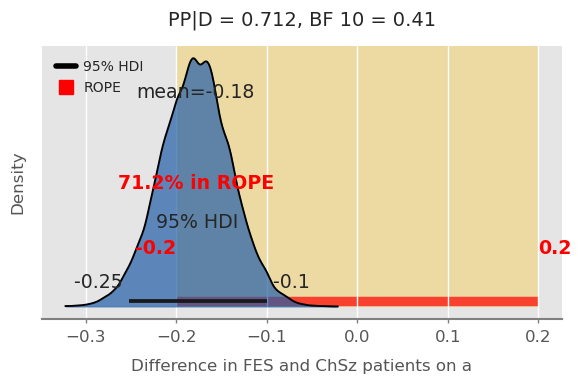

In [26]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['a(1)'].values.flatten()
a2_samples = m1_infdata.posterior['a(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"a(1) vs a(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

# 使用 fill_between 方法进行填充
ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on a', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/a1_vs_a2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()


Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
v(1) vs v(2) │        1.257 │        0.833 │          0.424 │         0.132 │         0.714 │ 0.064 │  14.75


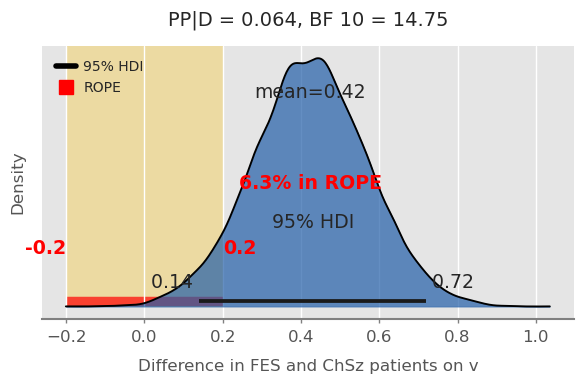

In [27]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['v(1)'].values.flatten()
a2_samples = m1_infdata.posterior['v(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"v(1) vs v(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

# 使用 fill_between 方法进行填充
ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on v', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/v1_vs_v2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()


Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
t(1) vs t(2) │        0.252 │        0.287 │         -0.035 │        -0.059 │        -0.011 │ 0.999 │   0.00


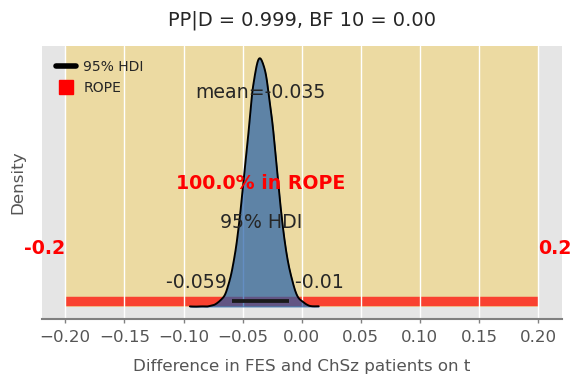

In [28]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['t(1)'].values.flatten()
a2_samples = m1_infdata.posterior['t(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"t(1) vs t(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on t', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/t1_vs_t2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()


Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
z(1) vs z(2) │        0.517 │        0.503 │          0.014 │        -0.006 │         0.034 │ 0.999 │   0.00


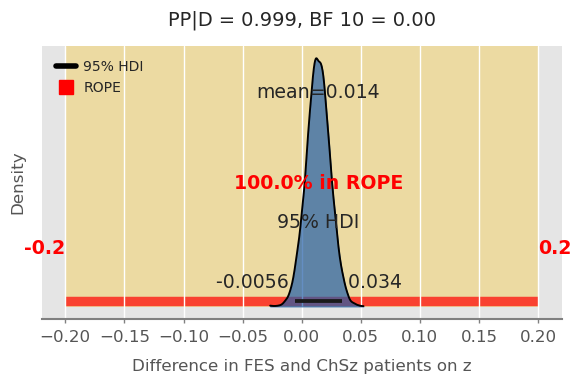

In [29]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['z(1)'].values.flatten()
a2_samples = m1_infdata.posterior['z(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"z(1) vs z(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on z', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/z1_vs_z2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()

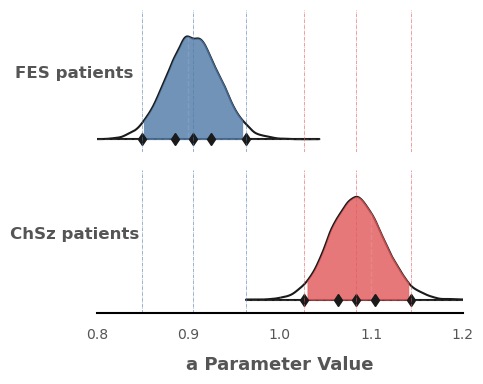

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m2_infdata 已经被正确加载，并且 m2_infdata 包含模型的后验样本
# 将 FES 和 ChSz 的样本数据提取到 model_data 字典中
model_data = {
    'FES': m1_infdata.posterior['a(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['a(2)'].values.flatten(),
}

# 设置要绘制的参数名称
parameters = ['a(1)', 'a(2)']

# 创建具有透明背景的图形
fig, axes = plt.subplots(figsize=(5, 4), nrows=2, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明

# 自定义颜色调色板，参考 Nature 配色
colors = ['#4E79A7', '#E15759']  # 蓝色 (FES) 和 红色 (ChSz)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate([model_data['FES'], model_data['ChSz']])
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 获取分位数信息
    fes_quantiles = np.percentile(model_data['FES'], [2.5, 50, 97.5])
    chsz_quantiles = np.percentile(model_data['ChSz'], [2.5, 50, 97.5])
    
    # 绘制虚线连接分位数
    axes[i].axvline(fes_quantiles[0], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[1], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[2], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[0], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[1], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[2], color=colors[1], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    axes[i].set_ylabel('FES patients' if i == 0 else 'ChSz patients', 
                      fontsize=12, rotation=0, labelpad=5,
                      weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(0.8, 1.2)
    
    # 自动生成合适数量的刻度
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))  # 设置大约5个主刻度
    
    # 设置刻度标签的字体大小和粗细
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为第二个子图（i=1）单独设置底部边框
    if i == 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('a Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-a.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

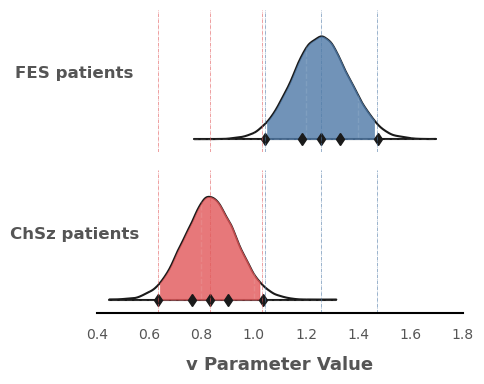

In [31]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m2_infdata 已经被正确加载，并且 m2_infdata 包含模型的后验样本
# 将 FES 和 ChSz 的样本数据提取到 model_data 字典中
model_data = {
    'FES': m1_infdata.posterior['v(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['v(2)'].values.flatten(),
}

# 设置要绘制的参数名称
parameters = ['v(1)', 'v(2)']

# 创建具有透明背景的图形
fig, axes = plt.subplots(figsize=(5, 4), nrows=2, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明


# 自定义颜色调色板，参考 Nature 配色
colors = ['#4E79A7', '#E15759']  # 蓝色 (FES) 和 红色 (ChSz)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate([model_data['FES'], model_data['ChSz']])
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 获取分位数信息
    fes_quantiles = np.percentile(model_data['FES'], [2.5, 50, 97.5])
    chsz_quantiles = np.percentile(model_data['ChSz'], [2.5, 50, 97.5])
    
    # 绘制虚线连接分位数
    axes[i].axvline(fes_quantiles[0], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[1], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[2], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[0], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[1], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[2], color=colors[1], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    axes[i].set_ylabel('FES patients' if i == 0 else 'ChSz patients', 
                      fontsize=12, rotation=0, labelpad=5,
                      weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(0.4, 1.8)
    
    # 自动生成合适数量的刻度
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(8))  # 设置大约5个主刻度
    
    # 设置刻度标签的字体大小和粗细
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为第二个子图（i=1）单独设置底部边框
    if i == 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('v Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-v.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

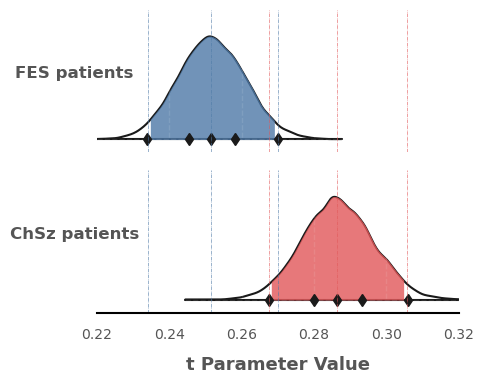

In [32]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m2_infdata 已经被正确加载，并且 m2_infdata 包含模型的后验样本
# 将 FES 和 ChSz 的样本数据提取到 model_data 字典中
model_data = {
    'FES': m1_infdata.posterior['t(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['t(2)'].values.flatten(),
}

# 设置要绘制的参数名称
parameters = ['t(1)', 't(2)']

# 创建具有透明背景的图形
fig, axes = plt.subplots(figsize=(5, 4), nrows=2, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明

# 自定义颜色调色板，参考 Nature 配色
colors = ['#4E79A7', '#E15759']  # 蓝色 (FES) 和 红色 (ChSz)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate([model_data['FES'], model_data['ChSz']])
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 获取分位数信息
    fes_quantiles = np.percentile(model_data['FES'], [2.5, 50, 97.5])
    chsz_quantiles = np.percentile(model_data['ChSz'], [2.5, 50, 97.5])
    
    # 绘制虚线连接分位数
    axes[i].axvline(fes_quantiles[0], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[1], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[2], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[0], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[1], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[2], color=colors[1], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    axes[i].set_ylabel('FES patients' if i == 0 else 'ChSz patients', 
                      fontsize=12, rotation=0, labelpad=5,
                      weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(0.22, 0.32)
    
    # 自动生成合适数量的刻度
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(5))  # 设置大约5个主刻度
    
    # 设置刻度标签的字体大小和粗细
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为第二个子图（i=1）单独设置底部边框
    if i == 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('t Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-t.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

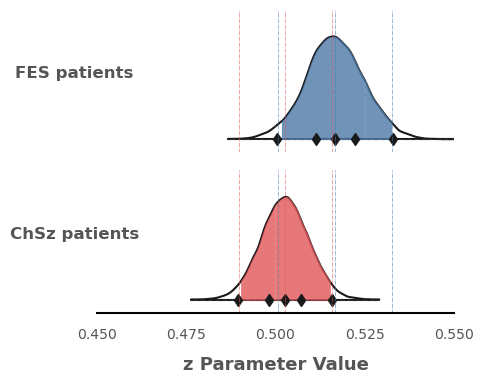

In [33]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m2_infdata 已经被正确加载，并且 m2_infdata 包含模型的后验样本
# 将 FES 和 ChSz 的样本数据提取到 model_data 字典中
model_data = {
    'FES': m1_infdata.posterior['z(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['z(2)'].values.flatten(),
}

# 设置要绘制的参数名称
parameters = ['z(1)', 'z(2)']

# 创建具有透明背景的图形
fig, axes = plt.subplots(figsize=(5, 4), nrows=2, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明


# 自定义颜色调色板，参考 Nature 配色
colors = ['#4E79A7', '#E15759']  # 蓝色 (FES) 和 红色 (ChSz)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate([model_data['FES'], model_data['ChSz']])
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 获取分位数信息
    fes_quantiles = np.percentile(model_data['FES'], [2.5, 50, 97.5])
    chsz_quantiles = np.percentile(model_data['ChSz'], [2.5, 50, 97.5])
    
    # 绘制虚线连接分位数
    axes[i].axvline(fes_quantiles[0], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[1], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(fes_quantiles[2], color=colors[0], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[0], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[1], color=colors[1], linestyle='-.', lw=0.4)
    axes[i].axvline(chsz_quantiles[2], color=colors[1], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    axes[i].set_ylabel('FES patients' if i == 0 else 'ChSz patients', 
                      fontsize=12, rotation=0, labelpad=5,
                      weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(0.45, 0.55)
    
    # 自动生成合适数量的刻度
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(5))  # 设置大约5个主刻度
    
    # 设置刻度标签的字体大小和粗细
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为第二个子图（i=1）单独设置底部边框
    if i == 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('z Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-z.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

In [34]:
print("代码全部完成!")

代码全部完成!
